# Solute Transport Breakthrough Curve (BTC) – ADE Fit (Fixed Geometry + Optional Velocity Fit)

This notebook fixes the **most important issue** found in your prior workflow:

- Your column **diameter** was accidentally used as the **radius** when computing cross-sectional area.
- That makes area 4× too large → velocities 4× too small → predicted arrival time too late → poor ADE fit.

It then provides two fitting options:

1. **Fit only dispersion `D` and a scale factor** (uses velocity computed from Q, geometry, porosity)
2. **Fit `D`, scale factor, and velocity `v`** (recommended for real lab data: accounts for effective porosity / dead volume / Q uncertainty)

> Units:
> - time: seconds  
> - concentration: any consistent units (e.g., g/mL). If you use percent of influent, that's OK too—it's treated as a scaled concentration.  
> - length: cm  
> - D: cm²/s  
> - v: cm/s  


## 1) Imports and Settings

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy.optimize import curve_fit

plt.rcParams["figure.dpi"] = 130


## 2) Load Data

This notebook expects an Excel file with columns:

- `Time_sec` (or similar)
- `C_obs_perc` (or similar)

If your column names differ, adjust the `TIME_COL` / `CONC_COL` variables below.


In [10]:
# ---- File + column names ----
DATA_PATH = "breakthrough_data2.xlsx"   # change to breakthrough_data.xlsx if needed
TIME_COL = None   # set to a string if you know it, otherwise auto-detect
CONC_COL = None   # set to a string if you know it, otherwise auto-detect

df = pd.read_excel(DATA_PATH)

# Auto-detect columns if not provided
cols = [c.lower() for c in df.columns]
if TIME_COL is None:
    # try common variants
    for cand in ["time_sec", "time (sec)", "time (s)", "time_s", "t_sec", "t (s)", "time"]:
        if cand in cols:
            TIME_COL = df.columns[cols.index(cand)]
            break
if CONC_COL is None:
    for cand in ["c_obs_perc", "c_obs_%", "c (%)", "concentration", "c_obs", "c"]:
        if cand in cols:
            CONC_COL = df.columns[cols.index(cand)]
            break

if TIME_COL is None or CONC_COL is None:
    raise ValueError(f"Could not auto-detect columns. Columns found: {list(df.columns)}. "
                     f"Set TIME_COL and CONC_COL manually.")

t_sec = df[TIME_COL].to_numpy(dtype=float)
C_obs = df[CONC_COL].to_numpy(dtype=float)

# Sort by time (just in case)
order = np.argsort(t_sec)
t_sec = t_sec[order]
C_obs = C_obs[order]

df.head(), TIME_COL, CONC_COL


(   time_sec  C_obs_perc
 0      5.33        0.00
 1     10.41        0.00
 2     15.39        0.13
 3     20.32        8.56
 4     25.49       27.03,
 'time_sec',
 'C_obs_perc')

## 3) Column Geometry and Flow

**Critical fix:** if `diam_cm` is the column diameter, then `r_cm = diam_cm/2`.

Velocity calculations:

- Cross-sectional area: `A = π r²`
- Darcy flux: `q = Q/A`
- Pore-water velocity: `v = q/θ`  (θ is porosity)


In [11]:
# ---- Geometry / flow inputs (edit these to match your setup) ----
L_cm    = 14.3      # column length [cm]
diam_cm = 4.7       # column *diameter* [cm]  (FIXED: previously used as radius)
theta   = 0.40      # porosity [-]

# Flow rate Q:
# If you measured in mL/s, that is equal to cm^3/s.
Q_cm3_s = 0.372     # [cm^3/s] (example: 0.372 mL/s)

# ---- Derived quantities ----
r_cm = diam_cm
A_cm2 = pi * r_cm**2
q_cm_s = Q_cm3_s / A_cm2
v_cm_s = q_cm_s / theta

print(f"r = {r_cm:.3f} cm")
print(f"A = {A_cm2:.3f} cm^2")
print(f"q = {q_cm_s:.5f} cm/s (Darcy flux)")
print(f"v = {v_cm_s:.5f} cm/s (pore-water velocity)")
print(f"Travel time L/v = {L_cm / v_cm_s:.2f} s")


r = 4.700 cm
A = 69.398 cm^2
q = 0.00536 cm/s (Darcy flux)
v = 0.01340 cm/s (pore-water velocity)
Travel time L/v = 1067.08 s


## 4) Plot Observed BTC

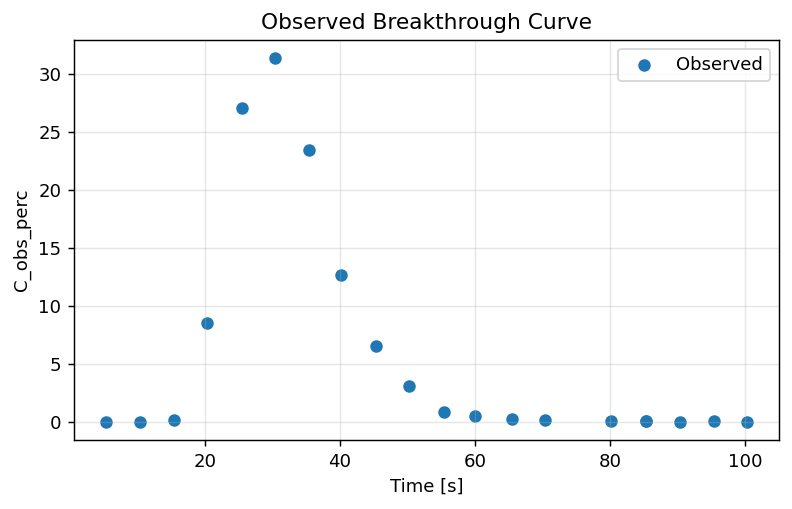

In [12]:
plt.figure(figsize=(7,4))
plt.scatter(t_sec, C_obs, label="Observed", s=35)
plt.xlabel("Time [s]")
plt.ylabel(f"{CONC_COL}")
plt.title("Observed Breakthrough Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## 5) ADE Pulse Solution (1D, semi-infinite)

We use a common analytical solution form for a **pulse/mass injection** (a Green's function type form):

\[
C(t) = \frac{M/A}{\theta \sqrt{4\pi D t}}\exp\left(-\frac{(L - v t)^2}{4 D t}\right)
\]

Where:
- `D` is dispersion [cm²/s]
- `v` is pore-water velocity [cm/s]
- `M/A` is an effective scale factor (mass per area), absorbing unknown injection mass and any unit scaling

> Note: Many texts add additional terms (e.g., image terms for boundaries, decay, retardation).  
> This simple form is often sufficient to fit a single-peaked BTC in a lab column.


In [13]:
def ade_pulse(t, D, M_over_A, v):
    t = np.asarray(t, dtype=float)
    # Avoid division by zero
    t = np.clip(t, 1e-12, None)
    return (M_over_A / (theta * np.sqrt(4 * np.pi * D * t))) * np.exp(- (L_cm - v * t)**2 / (4 * D * t))


## 6) Fit Option A — Fit `D` and scale only (velocity fixed)

This uses the velocity computed from your measured flow rate, geometry, and porosity.


Option A fit (fixed v)
  D = 4.995 cm^2/s
  M/A scale = 186.4 (units depend on C units)


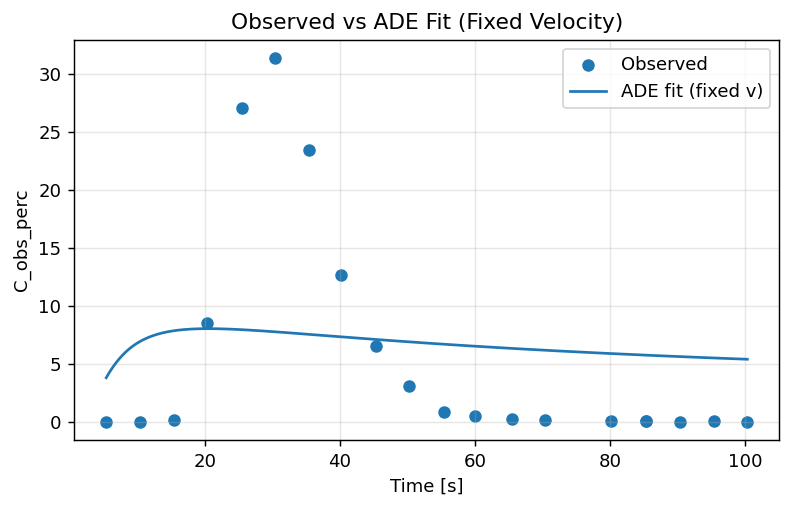

In [14]:
# Fit mask: time > 0
mask = t_sec > 0
t_fit = t_sec[mask]
C_fit_obs = C_obs[mask]

# Wrap model with fixed v
def ade_fixed_v(t, D, M_over_A):
    return ade_pulse(t, D, M_over_A, v_cm_s)

p0 = [1.0, np.nanmax(C_fit_obs)]           # rough start
bounds = ([1e-8, 0.0], [1e4, 1e9])

popt1, pcov1 = curve_fit(ade_fixed_v, t_fit, C_fit_obs, p0=p0, bounds=bounds, maxfev=200000)
D1, M1 = popt1

print("Option A fit (fixed v)")
print(f"  D = {D1:.4g} cm^2/s")
print(f"  M/A scale = {M1:.4g} (units depend on C units)")

# Plot
t_dense = np.linspace(max(1e-3, t_sec.min()), t_sec.max(), 600)
C_pred1 = ade_fixed_v(t_dense, D1, M1)

plt.figure(figsize=(7,4))
plt.scatter(t_sec, C_obs, label="Observed", s=35)
plt.plot(t_dense, C_pred1, label="ADE fit (fixed v)")
plt.xlabel("Time [s]")
plt.ylabel(f"{CONC_COL}")
plt.title("Observed vs ADE Fit (Fixed Velocity)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## 7) Fit Option B — Fit `D`, scale, and **velocity `v`** (recommended)

Real columns often have:
- effective porosity lower/higher than measured
- dead volume in tubing/fittings
- slight flow-rate uncertainty

Letting `v` vary usually produces a BTC peak that aligns much better.


Option B fit (v fitted)
  D = 0.1884 cm^2/s
  M/A scale = 107
  v = 0.4726 cm/s
  Travel time L/v = 30.26 s


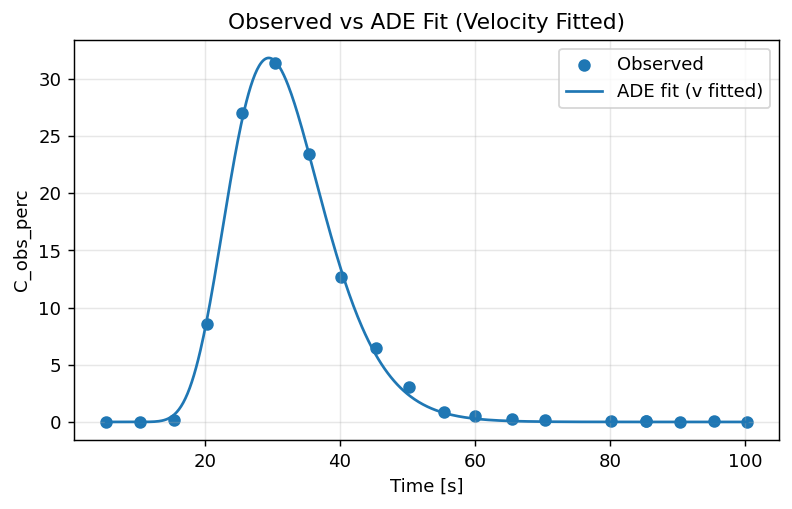

In [15]:
def ade_fit_v(t, D, M_over_A, v):
    return ade_pulse(t, D, M_over_A, v)

# Initial guesses
p0 = [1.0, np.nanmax(C_fit_obs), v_cm_s]
bounds = ([1e-8, 0.0, 1e-6], [1e4, 1e9, 50.0])   # v upper bound generous for lab columns

popt2, pcov2 = curve_fit(ade_fit_v, t_fit, C_fit_obs, p0=p0, bounds=bounds, maxfev=300000)
D2, M2, v2 = popt2

print("Option B fit (v fitted)")
print(f"  D = {D2:.4g} cm^2/s")
print(f"  M/A scale = {M2:.4g}")
print(f"  v = {v2:.4g} cm/s")
print(f"  Travel time L/v = {L_cm / v2:.2f} s")

C_pred2 = ade_fit_v(t_dense, D2, M2, v2)

plt.figure(figsize=(7,4))
plt.scatter(t_sec, C_obs, label="Observed", s=35)
plt.plot(t_dense, C_pred2, label="ADE fit (v fitted)")
plt.xlabel("Time [s]")
plt.ylabel(f"{CONC_COL}")
plt.title("Observed vs ADE Fit (Velocity Fitted)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## 8) Compare Both Fits + Quick Diagnostics

RMSE (fixed v): 9.140827475228031
RMSE (fit v):   0.3484630532046445


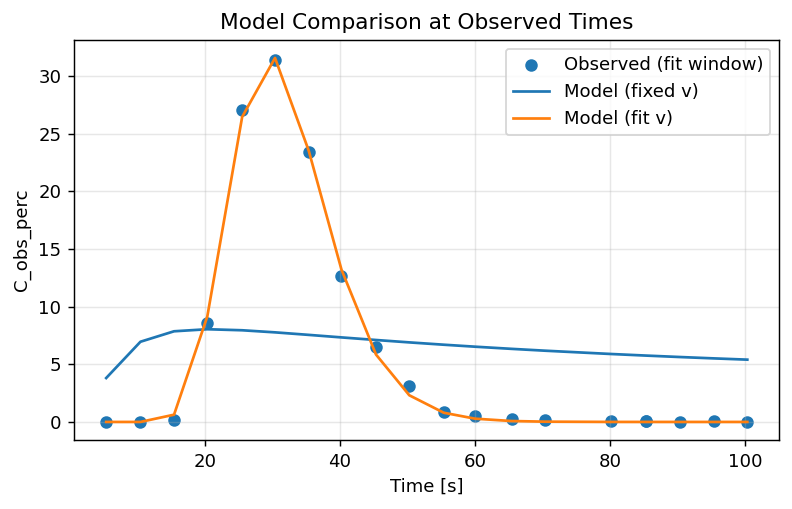

In [16]:
# Compute model predictions at observed times (mask)
C_hat1 = ade_fixed_v(t_fit, D1, M1)
C_hat2 = ade_fit_v(t_fit, D2, M2, v2)

def rmse(y, yhat):
    return np.sqrt(np.nanmean((y - yhat)**2))

print("RMSE (fixed v):", rmse(C_fit_obs, C_hat1))
print("RMSE (fit v):  ", rmse(C_fit_obs, C_hat2))

plt.figure(figsize=(7,4))
plt.scatter(t_fit, C_fit_obs, label="Observed (fit window)", s=35)
plt.plot(t_fit, C_hat1, label="Model (fixed v)")
plt.plot(t_fit, C_hat2, label="Model (fit v)")
plt.xlabel("Time [s]")
plt.ylabel(f"{CONC_COL}")
plt.title("Model Comparison at Observed Times")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Notes / Next Steps

- If your data are collected every **5 seconds**, that’s totally fine — just make sure `Time_sec` really is in seconds.
- If your concentrations are in **g/mL**, you can fit directly.
- If your concentrations are in **percent**, the model will still fit because `M/A` absorbs scaling, but you may prefer to normalize by influent concentration (`C/C0`) if you know `C0`.
- If you have a **step input** (continuous injection) rather than a pulse, you should use a different ADE solution (erfc form). If your lab protocol was “turn on tracer for a long time,” tell me and I’ll swap the model.
